In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pickle

In [23]:
# Functions

# Load csv file into a pandas DataFrame
def Load(file_path):
    data = pd.read_csv("data\\"+file_path)
    return data

# Clean text data
def clean_text(text):
    try:
        text = str(text)
        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        # Remove user mentions and hashtags
        text = re.sub(r'@\w+|#\w+', '', text)
        # Remove special characters except basic punctuation
        text = re.sub(r'[^\w\s]', ' ', text)
        # Convert to lowercase
        text = text.lower()
        # Remove extra whitespace (Separate into list of words and recombine)
        text = ' '.join(text.split())
        return text
    except Exception as e:
        print(f"Error cleaning text: {e}")
        return ""

In [64]:
# Load and clean data

# Movies file
df_movies = Load('tmdb_5000_movies.csv')                        # 3091 missing 'homepage' values and 844 missing 'tagline' values
#df_movies = df_movies.drop(['homepage', 'tagline'], axis=1)    # Drop columns with too many missing values
df_movies = df_movies.dropna(subset=['id'])                                 # Drop any remaining rows with missing values
df_movies = df_movies.fillna('')                  # Fill missing values with empty lists

print("tmdb_5000_movies.csv")
print(df_movies.isnull().sum(),'\n')                            # Verify no missing values remain
print(df_movies.shape[0],'rows\n')

# Credits file
df_credits = Load('tmdb_5000_credits.csv')      # No missing values
df_credits = df_credits[df_credits.columns.drop(list(df_credits.filter(regex='Unnamed')))]  # Drop any unnamed columns
df_credits = df_credits.dropna(subset=['movie_id'])                # Drop any remaining rows with missing values
df_credits = df_credits.fillna('')              # Fill missing values with empty lists

print("tmdb_5000_credits.csv")
print(df_credits.isnull().sum(),'\n')
print(df_credits.shape[0],'rows\n')

# Merge datasets on 'id' and 'movie_id'
df = pd.concat([df_movies.set_index('id'), df_credits.set_index('movie_id')], axis=1, join='outer').reset_index()
df = df.loc[:,~df.columns.duplicated()].copy()  # Remove any duplicate columns after merge
df = df.dropna(subset=['title'])
print("Merged DataFrame")
print(df.isnull().sum(),'\n')         # Verify no missing values remain
print(df.shape[0],'rows\n')


tmdb_5000_movies.csv
budget                  0
genres                  0
homepage                0
id                      0
keywords                0
original_language       0
original_title          0
overview                0
popularity              0
production_companies    0
production_countries    0
release_date            0
revenue                 0
runtime                 0
spoken_languages        0
status                  0
tagline                 0
title                   0
vote_average            0
vote_count              0
dtype: int64 

4803 rows

tmdb_5000_credits.csv
movie_id    0
title       0
cast        0
crew        0
dtype: int64 

1498 rows

Merged DataFrame
index                      0
budget                     0
genres                     0
homepage                   0
keywords                   0
original_language          0
original_title             0
overview                   0
popularity                 0
production_companies       0
production_countries  

C:\Users\noah\AppData\Local\Temp\ipykernel_24004\154416636.py:5: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,25

In [66]:
# Data preprocessing and cleaning
clean_genres = []                               # Clean 'genres' column                 
for film_genres in df['genres']:
    genres = []
    for genre in film_genres.split('}, '):
        try:
            genres.append((genre.split('"name": ')[1]).split('"')[1])
        except:
            genres.append(None)
    genres = clean_text(genres)
    clean_genres.append(genres)
df['clean_genres'] = clean_genres

clean_keywords = []                             # Clean 'keywords' column                 
for film_keywords in df['keywords']:
    keywords = []
    for keyword in film_keywords.split('}, '):
        try:
            keywords.append((keyword.split('"name": ')[1]).split('"')[1])
        except:
            keywords.append(None)
    keywords = clean_text(keywords)
    clean_keywords.append(keywords)
df['clean_keywords'] = clean_keywords

clean_overview = []                             # Clean 'overview' column                 
for film_overview in df['overview']:
    film_overview = clean_text(film_overview)
    clean_overview.append(film_overview)
df['clean_overview'] = clean_overview

clean_release_date = []                         # Clean 'release_date' column                 
for film_release_date in df['release_date']:
    film_release_date = clean_text(film_release_date)[:7] # Keep only the year and month
    clean_release_date.append(film_release_date)
df['clean_release_date'] = clean_release_date

clean_runtime = []                              # Clean 'runtime' column                 
for film_runtime in df['runtime']:
    film_runtime = clean_text(film_runtime)[:-2] # keep only the numeric part
    clean_runtime.append(film_runtime)
df['clean_runtime'] = clean_runtime

clean_spoken_languages = []                     # Clean 'spoken_languages' column                 
for film_spoken_languages in df['spoken_languages']:
    spoken_languages = []
    for language in film_spoken_languages.split('}, '):
        try:
            spoken_languages.append((language.split('"iso_639_1": ')[1]).split('"')[1])
        except:
            spoken_languages.append(None)
    spoken_languages = clean_text(spoken_languages)
    clean_spoken_languages.append(spoken_languages)
df['clean_spoken_languages'] = clean_spoken_languages

clean_cast = []                                 # Clean 'cast' column                 
for film_cast in df['cast']:
    cast = []
    for actor in str(film_cast).split('}, '):
        try:
            cast.append((actor.split('"name": ')[1]).split('"')[1].replace(' ', '_')) # Combine first and last names
        except:
            cast.append(None)
    cast = clean_text(cast)
    clean_cast.append(cast)
df['clean_cast'] = clean_cast

# Create 'tags' column by combining relevant features
df['tags'] = df['clean_genres'] + ' ' + df['clean_keywords'] + ' ' + df['clean_overview'] + ' ' + df['clean_release_date'] + ' ' + df['clean_runtime'] + ' ' + df['clean_spoken_languages'] + ' ' + df['clean_cast']
print(df['tags'][0])
print(type(df['tags']), '\n')

# Create a lowercase version of the 'title' column for case-insensitive matching
df['title_lower'] = df['title'].apply(lambda x: x.lower())

action adventure fantasy science fiction culture clash future space war space colony society space travel futuristic romance space alien tribe alien planet cgi marine soldier battle love affair anti war power relations mind and soul 3d in the 22nd century a paraplegic marine is dispatched to the moon pandora on a unique mission but becomes torn between following orders and protecting an alien civilization 2009 12 162 en es none
<class 'pandas.core.series.Series'> 



In [67]:
# Vectorise 'tags' column
vectorizer = CountVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))  # Limit to top 5000 features
vectors = vectorizer.fit_transform(df['tags'])
print(vectors.toarray().shape)
print(np.count_nonzero(vectors.toarray()))
print(type(vectorizer))
print(type(vectors),'\n')

# Compute cosine similarity matrix
cosine_sim = cosine_similarity(vectors)
print(type(cosine_sim))
df['similarity'] = list(cosine_sim)

# Save processed DataFrame and cosine similarity matrix
pickle.dump(df, open('model.pkl', 'wb'))
pickle.dump(cosine_sim, open('similarity.pkl', 'wb'))

(4803, 5000)
187299
<class 'sklearn.feature_extraction.text.CountVectorizer'>
<class 'scipy.sparse._csr.csr_matrix'> 

<class 'numpy.ndarray'>


Top 10 similar films to 'The Hitchhiker's Guide to the Galaxy':
The 5th Wave
Home
Planet 51
The Host
Ender's Game
Stargate: The Ark of Truth
Meet Dave
Mars Needs Moms
The Invasion
Lost in Space


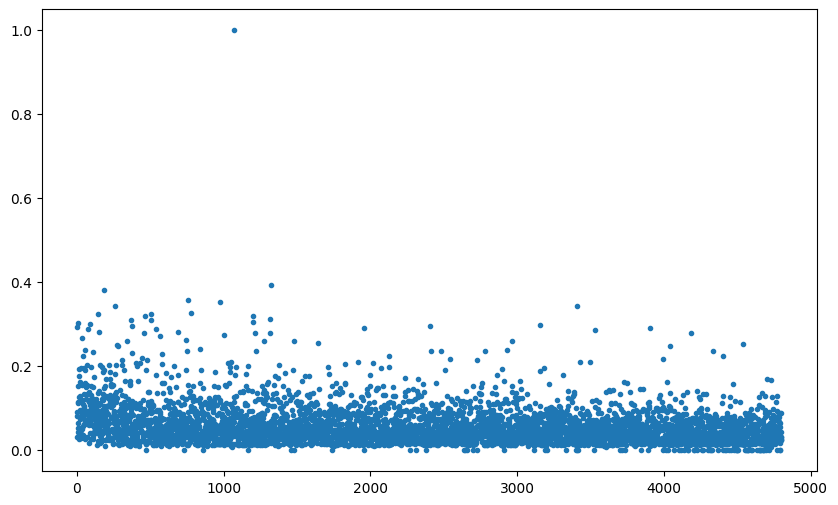

In [74]:
def get_similar_films(film_title, no_of_recommendations):
    # Get top 5 similar films (excluding itself)
    try:
        film_title = film_title.lower() # Convert to lowercase for matching...
        film_no = df[df['title_lower'] == film_title].index[0]
        similar_films = sorted(list(enumerate(cosine_sim[film_no])), reverse=True, key=lambda x: x[1])[1:(no_of_recommendations + 1)]
        print("Top {} similar films to '{}':".format(no_of_recommendations, df['title'][film_no])) # ...But use original case for display
        for i in similar_films:
            print(df['title'][i[0]])
    except IndexError:
        print(f"Film titled '{film_title}' not found in the database.")

film_title = "the Hitchhiker's Guide to the Galaxy"  # Change this value to test different films
no_of_recommendations = 10  # Number of recommendations to display
get_similar_films(film_title, no_of_recommendations)

# Plot cosine similarity values
film_title = film_title.lower()
film_no = df[df['title_lower'] == film_title].index[0]
x = np.arange(len(cosine_sim[film_no]))
plt.rcParams["figure.figsize"] = (10,6)
plt.plot(cosine_sim[film_no], '.')